In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# Download and save the dataset
import requests
import os

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

if not os.path.exists("./edx_train.csv"):
    save_file('https://courses.cs.washington.edu/courses/cse416/21sp/homework/hw6/edx_train.csv', 
          'edx_train.csv')
if not os.path.exists("./edx_test.csv"):
    save_file('https://courses.cs.washington.edu/courses/cse416/21sp/homework/hw6/edx_test.csv', 
          'edx_test.csv')

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset


In [38]:
# encoding data
import pandas as pd
train = pd.read_csv("./edx_train.csv", na_values=" ")
print(train.shape)
train.head(5)


(8758, 18)


,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,MHxPC130545492,1,1,1,1,United States,Master's,1984.0,m,1.00,3/10/13,7/29/13,1161.0,50.0,NaN,12.0,0
1,HarvardX/ER22x/2013_Spring,MHxPC130536944,1,1,1,1,United Kingdom,Master's,1985.0,f,0.85,3/13/13,8/1/13,1360.0,10.0,NaN,29.0,0
2,HarvardX/CS50x/2012,MHxPC130442298,1,1,1,1,India,NaN,NaN,NaN,1.00,8/2/12,7/25/13,77.0,18.0,NaN,7.0,0
3,HarvardX/ER22x/2013_Spring,MHxPC130273564,1,1,1,1,United Kingdom,Bachelor's,1982.0,m,0.85,1/23/13,8/13/13,1425.0,29.0,NaN,34.0,0
4,HarvardX/CS50x/2012,MHxPC130247761,1,1,0,0,United States,Secondary,1989.0,m,0.00,3/5/13,3/5/13,6.0,1.0,NaN,1.0,0


In [39]:
test = pd.read_csv("./edx_test.csv", na_values=" ")
print(test.shape)
test.head(5)

(2920, 17)


,course_id,userid_DI,registered,viewed,explored,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,MHxPC130476531,1,1,1,United Kingdom,Secondary,1971.0,m,1.00,10/30/12,6/27/13,132.0,34.0,NaN,12.0,0
1,HarvardX/CB22x/2013_Spring,MHxPC130559898,1,0,0,Other South Asia,Bachelor's,1984.0,m,NaN,2/6/13,11/17/13,NaN,NaN,NaN,NaN,0
2,HarvardX/PH207x/2012_Fall,MHxPC130552712,1,1,1,Egypt,Bachelor's,1985.0,f,0.81,10/20/12,1/18/13,2650.0,32.0,96.0,15.0,0
3,HarvardX/PH278x/2013_Spring,MHxPC130394971,1,1,1,Nigeria,Secondary,1988.0,m,0.87,12/27/12,8/22/13,999.0,17.0,13.0,8.0,0
4,HarvardX/ER22x/2013_Spring,MHxPC130191077,1,1,1,Other Middle East/Central Asia,NaN,NaN,NaN,0.90,5/31/13,9/7/13,2130.0,24.0,NaN,29.0,0


In [40]:
def process_frame(frame : pd.DataFrame):
    def encoding(column_name : str, data_frame : pd.DataFrame):
        series = data_frame[column_name]
        unique_entries = series.unique().tolist()
        mapping_dict = {unique_entries[i] : i for i in range(len(unique_entries))}
        mapped_ids = series.apply(lambda x : mapping_dict[x])
        return mapped_ids
    def encoding_gender_lambda(gender : str):
        if (gender == 'm'):
            return 0
        elif (gender == 'f'):
            return 1
        else:
            return -1
    def norm(column : str, data : pd.DataFrame):
        return (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    frame['course_id'] = encoding('course_id', frame)
    frame['final_cc_cname_DI'] = encoding('final_cc_cname_DI', frame)
    frame['LoE_DI'] = encoding('LoE_DI', frame)
    frame['gender'] = frame.gender.apply(lambda x: encoding_gender_lambda(x))
    frame['YoB'] = frame['YoB'].fillna(frame['YoB'].mean())
   
    frame = frame.drop(['userid_DI', 'start_time_DI', 'last_event_DI'], axis=1)
    frame = frame.fillna(-1)

    frame['YoB'] = norm('YoB', frame)
    frame['nevents'] = norm('nevents', frame)
    frame['ndays_act'] = norm('ndays_act', frame)
    frame['nplay_video'] = norm('nplay_video', frame)
    frame['nchapters'] = norm('nchapters', frame)
    frame['nforum_posts'] = norm('nforum_posts', frame)
    frame['grade'] = pd.to_numeric(frame['grade'], downcast="float")
    frame['grade'] = norm('grade', frame)

    return frame

In [41]:
train = process_frame(train)
train

,course_id,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,0,1,1,1,1,0,0,0.654321,0,0.995025,0.031035,0.31875,0.000000,0.371429,0.000000
1,1,1,1,1,1,1,0,0.666667,1,0.920398,0.036351,0.06875,0.000000,0.857143,0.000000
2,0,1,1,1,1,2,1,0.652417,-1,0.995025,0.002083,0.11875,0.000000,0.228571,0.000000
3,1,1,1,1,1,1,2,0.629630,0,0.920398,0.038087,0.18750,0.000000,1.000000,0.000000
4,0,1,1,0,0,0,3,0.716049,0,0.497512,0.000187,0.01250,0.000000,0.057143,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,0,1,0,0,0,7,2,0.753086,0,0.497512,0.000000,0.00000,0.000000,0.000000,0.000000
8754,2,1,1,1,1,2,0,0.506173,1,0.995025,0.052429,0.10625,0.006526,0.400000,0.000000
8755,0,1,0,0,0,7,4,0.518519,0,0.497512,0.000000,0.00000,0.000000,0.000000,0.000000
8756,1,1,1,1,1,0,0,0.617284,0,0.990050,0.029673,0.15000,0.000000,0.942857,0.285714


In [42]:
test = process_frame(test)
test

,course_id,registered,viewed,explored,final_cc_cname_DI,LoE_DI,YoB,gender,grade,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,0,1,1,1,0,0,0.546875,0,0.995025,0.004233,0.291667,0.000000,0.371429,0.0
1,1,1,0,0,1,1,0.750000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,2,1,1,1,2,1,0.765625,1,0.900497,0.084381,0.275000,0.010233,0.457143,0.0
3,3,1,1,1,3,0,0.812500,0,0.930348,0.031830,0.150000,0.001477,0.257143,0.0
4,4,1,1,1,4,2,0.746516,-1,0.945274,0.067830,0.208333,0.000000,0.857143,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,0,1,0,0,12,1,0.734375,0,0.497512,0.000000,0.000000,0.000000,0.000000,0.0
2916,0,1,1,1,21,0,0.796875,0,0.497512,0.005666,0.066667,0.000000,0.371429,0.0
2917,2,1,1,0,2,2,0.875000,1,0.507463,0.038164,0.083333,0.041988,0.114286,0.0
2918,4,1,1,0,23,1,0.859375,0,0.860697,0.006080,0.016667,0.000000,0.142857,0.0


In [43]:
certified = train['certified']
train = train.drop(['certified'], axis=1)
# train = train.astype(np.float64)
train.head(5)

,course_id,registered,viewed,explored,final_cc_cname_DI,LoE_DI,YoB,gender,grade,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,0,1,1,1,0,0,0.654321,0,0.995025,0.031035,0.31875,0.0,0.371429,0.0
1,1,1,1,1,1,0,0.666667,1,0.920398,0.036351,0.06875,0.0,0.857143,0.0
2,0,1,1,1,2,1,0.652417,-1,0.995025,0.002083,0.11875,0.0,0.228571,0.0
3,1,1,1,1,1,2,0.629630,0,0.920398,0.038087,0.18750,0.0,1.000000,0.0
4,0,1,1,0,0,3,0.716049,0,0.497512,0.000187,0.01250,0.0,0.057143,0.0


In [44]:
train.dtypes

course_id              int64
registered             int64
viewed                 int64
explored               int64
final_cc_cname_DI      int64
LoE_DI                 int64
YoB                  float64
gender                 int64
grade                float32
nevents              float64
ndays_act            float64
nplay_video          float64
nchapters            float64
nforum_posts         float64
dtype: object

In [45]:
# train.to_csv("processed_train.csv")
# certified.to_csv("train_labels.csv")

In [46]:
train_data = train.to_numpy().astype(np.float32)
train_label = certified.to_numpy()

In [47]:
test_data = test.to_numpy().astype(np.float32)

In [48]:
print(train_data.dtype)

float32


In [49]:
import random
seed = 0
np.random.seed(seed)
torch.random.manual_seed(seed)
random.seed(seed)

In [50]:
from sklearn.model_selection import train_test_split
# train_data, eval_data, train_label, eval_label = train_test_split(train_data, train_label, test_size=0.1, random_state=seed)
_, eval_data, _, eval_label = train_test_split(train_data, train_label, test_size=0.1, random_state=seed)

In [51]:
class Dataset(Dataset):

    def __init__(self, data, labels, is_test=False):
        self.data = data
        # if (is_test == False):
        self.labels = labels
        # else:
        #     self.labels = None
        self.is_test = is_test
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.is_test:
            return torch.from_numpy(self.data[idx])
        return torch.from_numpy(self.data[idx]), self.labels[idx]

In [52]:
training_dataset = Dataset(train_data, train_label)
eval_dataset = Dataset(eval_data, eval_label)
testing_dataset = Dataset(test_data, None, is_test=True)

In [53]:
training_dataset[0][0].shape[0]

14

In [54]:
class SimpleResNN(nn.Module):
    def __init__(self, in_features, out_features = 2, hidden_features = None, n_blocks = 3):
        super().__init__()
        if hidden_features == None:
            hidden_features = (in_features // 2)
        # self.input = BottleNeck(in_features, in_features, hidden_features)
        layers = []
        for _ in range(n_blocks):
            layers += [BottleNeck(in_features, in_features, hidden_features)]
        self.hidden_blocks = nn.Sequential(*layers)
        self.output = nn.Linear(in_features, out_features)
    def forward(self, x):
        x = self.hidden_blocks(x)
        x = self.output(x)
        return x

class BottleNeck(nn.Module):
    def __init__(self, in_features, out_features, hidden_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.bn = nn.BatchNorm1d(hidden_features)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        identity = x
        
        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.fc2(x)
        x += identity
        x = self.relu(x)

        return x

class ReallySimpleNN(nn.Module):
    def __init__(self, in_features, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features, out_features)
    def forward(self, x):
        x = self.fc1(x)
        return x

In [55]:
model = SimpleResNN(training_dataset[0][0].shape[0], 2, 11, 4) #magic 11
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleResNN(
  (hidden_blocks): Sequential(
    (0): BottleNeck(
      (fc1): Linear(in_features=14, out_features=11, bias=True)
      (fc2): Linear(in_features=11, out_features=14, bias=True)
      (bn): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BottleNeck(
      (fc1): Linear(in_features=14, out_features=11, bias=True)
      (fc2): Linear(in_features=11, out_features=14, bias=True)
      (bn): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): BottleNeck(
      (fc1): Linear(in_features=14, out_features=11, bias=True)
      (fc2): Linear(in_features=11, out_features=14, bias=True)
      (bn): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): BottleNeck(
      (fc1): Linear(in_features=14, out_features=11, bias=True)
      (fc2): Linear(in_features

In [56]:
from  torch.utils.data import DataLoader
train_dataloader = DataLoader(training_dataset, batch_size=512, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=512, shuffle=False)
test_dataloader = DataLoader(testing_dataset, batch_size=1, shuffle=False)

In [57]:
def train(model, loss_func, optimizer, dataloader, testloader, epoch=100):
    train_results = []
    eval_results = []
    train_loss_history = []
    eval_loss_history = []
    train_acc_history = []
    eval_acc_history = []
    model.train()
    for curr_epoch in range(epoch):
        train_loss_meter = 0
        eval_loss_meter = 0
        for i, data in enumerate(dataloader):
            input = data[0].cuda()
            label = data[1].cuda()

            output = model(input)
            loss = loss_func(output, label)

            predict = torch.argmax(output, dim=1).flatten()
            train_results += (predict == label).detach().cpu().tolist()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = loss.item()
            train_loss_meter += loss * data[0].size(0)

        avg_main_loss = train_loss_meter / len(dataloader.sampler)
        main_acc = sum(train_results) / len(train_results)
        
        logger_message = f"Epoch: [{curr_epoch+1}/{epoch}] \n"
        logger_message += f"Train Loss {avg_main_loss:.4f} "
        logger_message += "Acc: " + str(main_acc)
        print(logger_message)

        train_loss_history.append(avg_main_loss)
        train_acc_history.append(main_acc)

        model.eval()
        
        for i, data in enumerate(testloader):
            input = data[0].cuda()
            label = data[1].cuda()

            with torch.inference_mode():
                output = model(input)
                loss = loss_func(output, label)

            predict = torch.argmax(output, dim=1).flatten()
            eval_results += (predict == label).detach().cpu().tolist()

            loss = loss.item()
            eval_loss_meter += loss * data[0].size(0)
        
        model.train()
        
        avg_eval_loss = eval_loss_meter / len(testloader.sampler)
        eval_acc = sum(eval_results) / len(eval_results)

        logger_message = ""
        logger_message += f"Eval Loss {avg_eval_loss:.4f} "
        logger_message += "Acc: " + str(eval_acc) + "\n"
        print(logger_message)
        
        eval_loss_history.append(avg_eval_loss)
        eval_acc_history.append(eval_acc)
        
        train_results.clear()
        eval_results.clear()
    
    return train_loss_history, train_acc_history, eval_loss_history, eval_acc_history
            

In [58]:
def test(model, results, dataloader):
    model.eval()
  
    for i, data in enumerate(dataloader):
        input = data.cuda()

        with torch.inference_mode():
            output = model(input)
            predict = int(torch.argmax(output))
            results.append(predict)
        
        logger_message = f"Eval: [{i}/{len(dataloader.dataset)}] "
        logger_message += f"Predict {predict} "
        print(logger_message)

In [59]:
train_loss_history, train_acc_history, eval_loss_history, eval_acc_history = train(model, loss, optimizer, train_dataloader, eval_dataloader, 250)

Epoch: [1/150] 
Train Loss 1.0643 Acc: 0.5068508791961636
Eval Loss 0.9102 Acc: 0.519406392694064

Epoch: [2/150] 
Train Loss 0.7310 Acc: 0.6016213747430921
Eval Loss 0.5883 Acc: 0.7248858447488584

Epoch: [3/150] 
Train Loss 0.4912 Acc: 0.8605846083580726
Eval Loss 0.3948 Acc: 0.9041095890410958

Epoch: [4/150] 
Train Loss 0.3303 Acc: 0.9387988125142727
Eval Loss 0.2847 Acc: 0.932648401826484

Epoch: [5/150] 
Train Loss 0.2250 Acc: 0.9386846311943366
Eval Loss 0.1964 Acc: 0.934931506849315

Epoch: [6/150] 
Train Loss 0.1445 Acc: 0.9579812742635305
Eval Loss 0.1375 Acc: 0.9668949771689498

Epoch: [7/150] 
Train Loss 0.0847 Acc: 0.9860698789678009
Eval Loss 0.0808 Acc: 0.9851598173515982

Epoch: [8/150] 
Train Loss 0.0558 Acc: 0.9899520438456269
Eval Loss 0.0679 Acc: 0.9840182648401826

Epoch: [9/150] 
Train Loss 0.0379 Acc: 0.9928065768440283
Eval Loss 0.0493 Acc: 0.9920091324200914

Epoch: [10/150] 
Train Loss 0.0281 Acc: 0.9946334779630053
Eval Loss 0.0405 Acc: 0.9920091324200914

Ep

In [60]:
import matplotlib.pyplot as plt

def plot_history(histories : list, ylim : list):   
    x = [i for i in range(len(histories[0]))]
    fig, ax = plt.subplots()
    for history in histories:
        ax.plot(x, history, linewidth=2.0)
    ax.set(
       ylim=ylim)
    plt.show()


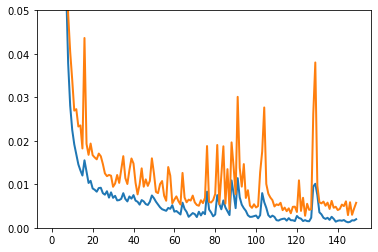

In [61]:
plot_history([train_loss_history, eval_loss_history], [0,0.05])

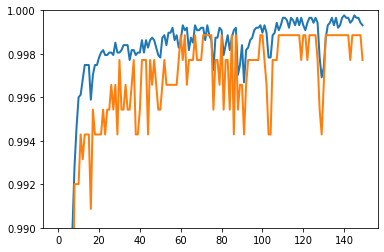

In [62]:
plot_history([train_acc_history, eval_acc_history], [0.99,1])

In [63]:
result = []
test(model, result, test_dataloader)

Eval: [0/2920] Predict 1 
Eval: [1/2920] Predict 0 
Eval: [2/2920] Predict 1 
Eval: [3/2920] Predict 1 
Eval: [4/2920] Predict 1 
Eval: [5/2920] Predict 0 
Eval: [6/2920] Predict 0 
Eval: [7/2920] Predict 0 
Eval: [8/2920] Predict 1 
Eval: [9/2920] Predict 1 
Eval: [10/2920] Predict 1 
Eval: [11/2920] Predict 1 
Eval: [12/2920] Predict 1 
Eval: [13/2920] Predict 1 
Eval: [14/2920] Predict 0 
Eval: [15/2920] Predict 0 
Eval: [16/2920] Predict 0 
Eval: [17/2920] Predict 0 
Eval: [18/2920] Predict 1 
Eval: [19/2920] Predict 1 
Eval: [20/2920] Predict 1 
Eval: [21/2920] Predict 0 
Eval: [22/2920] Predict 0 
Eval: [23/2920] Predict 0 
Eval: [24/2920] Predict 0 
Eval: [25/2920] Predict 1 
Eval: [26/2920] Predict 1 
Eval: [27/2920] Predict 0 
Eval: [28/2920] Predict 0 
Eval: [29/2920] Predict 1 
Eval: [30/2920] Predict 0 
Eval: [31/2920] Predict 0 
Eval: [32/2920] Predict 1 
Eval: [33/2920] Predict 1 
Eval: [34/2920] Predict 1 
Eval: [35/2920] Predict 1 
Eval: [36/2920] Predict 0 
Eval: [37/2

In [64]:
print(result)

[1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 

In [65]:
df_test = pd.read_csv('edx_test.csv')

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = result
to_save.to_csv('submission.csv', index=False)